# Outlook

In this notebook, using BBRL, we code the DDPG algorithm.

To understand this code, you need to know more about [the BBRL interaction
model](https://github.com/osigaud/bbrl/blob/master/docs/overview.md) Then you
should run [a didactical
example](https://github.com/osigaud/bbrl/blob/master/docs/notebooks/03-multi_env_autoreset.student.ipynb)
to see how agents interact in BBRL when autoreset=True.

The DDPG algorithm is explained in [this
video](https://www.youtube.com/watch?v=0D6a0a1HTtc) and you can also read [the
corresponding slides](http://pages.isir.upmc.fr/~sigaud/teach/ddpg.pdf).

In [2]:
# Prepare the environment
try:
    from easypip import easyimport
except ModuleNotFoundError:
    from subprocess import run

    assert (
        run(["pip", "install", "easypip"]).returncode == 0
    ), "Could not install easypip"
    from easypip import easyimport

easyimport("swig")
easyimport("bbrl_utils").setup(maze_mdp=True)

import os
import copy
import math
import bbrl_gymnasium  # noqa: F401
import torch
import torch.nn as nn
from bbrl.agents import Agent, Agents, TemporalAgent
from bbrl_utils.algorithms import EpochBasedAlgo
from bbrl_utils.nn import build_mlp, setup_optimizer, soft_update_params
from bbrl_utils.notebook import setup_tensorboard
from bbrl.visu.plot_policies import plot_policy
from omegaconf import OmegaConf

c:\Users\asola\.conda\envs\deepdac\lib\site-packages\bbrl_utils\notebook.py:46: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm  # noqa: F401


# Learning environment

## Configuration

The learning environment is controlled by a configuration providing a few
important things as described in the example below. This configuration can
hold as many extra information as you need, the example below is the minimal
one.

```python
params = {
    # This defines the a path for logs and saved models
    "base_dir": "${gym_env.env_name}/myalgo_${current_time:}",

    # The Gymnasium environment
    "gym_env": {
        "env_name": "CartPoleContinuous-v1",
    },

    # Algorithm
    "algorithm": {
        # Seed used for the random number generator
        "seed": 1023,

        # Number of parallel training environments
        "n_envs": 8,

        # Number of transitions to collect at each epoch for an environment.
        # This number has to be multiplied by n_envs to get the number of new transitions
        # collected at each epoch.
        "n_steps": 100,

        # Number of transitions before starting to train
        "learning_starts": 10_000,
                
        # Minimum number of steps between two evaluations
        "eval_interval": 500,
        
        # Number of parallel evaluation environments
        "nb_evals": 10,

        # Number of epochs (loops)
        "max_epochs": 40000,
    },
}

# Creates the configuration object, i.e. cfg.algorithm.nb_evals is 10
cfg = OmegaConf.create(params)
```

## The RL algorithm

In this notebook, the RL algorithm is based on `EpochBasedAlgo`, that defines
the algorithm environment when using episodes. To use such environment, we
just need to subclass `EpochBasedAlgo` and to define two things, namely the
`train_policy` and the `eval_policy`. Both are BBRL agents that, given the
environment state, select the action to perform.

```py
  class MyAlgo(EpochBasedAlgo):
      def __init__(self, cfg):
          super().__init__(cfg)

          # Define the train and evaluation policies
          # (the agents compute the workspace `action` variable)
          self.train_policy = MyPolicyAgent(...)
          self.eval_policy = MyEvalAgent(...)

algo = MyAlgo(cfg)
```

The `EpochBasedAlgo` defines useful objects:

- `algo.cfg` is the configuration
- `algo.nb_steps` (integer) is the number of steps since the training began
- `algo.logger` is a logger that can be used to collect statistics during training:
    - `algo.logger.add_log("critic_loss", critic_loss, algo.nb_steps)` registers the `critic_loss` value on tensorboard
- `algo.evaluate()` evaluates the current `eval_policy` if needed, and keeps the
agent if it was the best so far (average cumulated reward);
- `algo.visualize_best()` runs the best agent on one episode, and displays the video

The [DDPG](https://arxiv.org/pdf/1509.02971.pdf) algorithm is an actor critic
algorithm. We use a simple neural network builder function. This neural
networks plays the role of the actor and the critic.

## Definition of agents

The critic is a neural network taking the state $s$ and action $a$ as input,
and its output layer has a unique neuron whose value is the value of being in
that state and performing that action $Q(s,a)$.

As usual, the ```forward(...)``` function is used to write Q-values in the
workspace from time indexes.

In [3]:
class ContinuousQAgent(Agent):
    def __init__(self, state_dim, hidden_layers, action_dim):
        super().__init__()
        self.is_q_function = True
        self.model = build_mlp(
            [state_dim + action_dim] + list(hidden_layers) + [1], activation=nn.ReLU()
        )

    def forward(self, t):
        # Get the current state $s_t$ and the chosen action $a_t$
        obs = self.get(("env/env_obs", t))  # shape B x D_{obs}
        action = self.get(("action", t))  # shape B x D_{action}

        # Compute the Q-value(s_t, a_t)
        obs_act = torch.cat((obs, action), dim=1)  # shape B x (D_{obs} + D_{action})
        # Get the q-value (and remove the last dimension since it is a scalar)
        q_value = self.model(obs_act).squeeze(-1)
        self.set((f"{self.prefix}q_value", t), q_value)

The actor is also a neural network, it takes a state $s$ as input and outputs
an action $a$.

In [4]:
class ContinuousDeterministicActor(Agent):
    def __init__(self, state_dim, hidden_layers, action_dim):
        super().__init__()
        layers = [state_dim] + list(hidden_layers) + [action_dim]
        self.model = build_mlp(
            layers, activation=nn.ReLU(), output_activation=nn.Tanh()
        )

    def forward(self, t, **kwargs):
        obs = self.get(("env/env_obs", t))
        action = self.model(obs)
        self.set(("action", t), action)

### Creating an Exploration method

In the continuous action domain, basic exploration differs from the methods
used in the discrete action domain. Here we generally add some Gaussian noise
to the output of the actor.

In [5]:
from torch.distributions import Normal

In [6]:
class AddGaussianNoise(Agent):
    def __init__(self, sigma):
        super().__init__()
        self.sigma = sigma

    def forward(self, t, **kwargs):
        act = self.get(("action", t))
        dist = Normal(act, self.sigma)
        action = dist.sample()
        self.set(("action", t), action)

In [the original DDPG paper](https://arxiv.org/pdf/1509.02971.pdf), the
authors rather used the more sophisticated Ornstein-Uhlenbeck noise where
noise is correlated between one step and the next.

In [7]:
class AddOUNoise(Agent):
    """
    Ornstein-Uhlenbeck process noise for actions as suggested by DDPG paper
    """

    def __init__(self, std_dev, theta=0.15, dt=1e-2):
        self.theta = theta
        self.std_dev = std_dev
        self.dt = dt
        self.x_prev = 0

    def forward(self, t, **kwargs):
        act = self.get(("action", t))
        x = (
            self.x_prev
            + self.theta * (act - self.x_prev) * self.dt
            + self.std_dev * math.sqrt(self.dt) * torch.randn(act.shape)
        )
        self.x_prev = x
        self.set(("action", t), x)

### Compute critic loss

Detailed explanations of the function to compute the critic loss
are given in [the DQN notebook](http://master-dac.isir.upmc.fr/rld/rl/03-1-dqn-introduction.student.ipynb)

In [8]:
# Defines the (Torch) mse loss function
# `mse(x, y)` computes $\|x-y\|^2$
mse = nn.MSELoss()


def compute_critic_loss(cfg, reward: torch.Tensor, must_bootstrap: torch.Tensor, q_values: torch.Tensor, target_q_values: torch.Tensor):
    """Compute the DDPG critic loss from a sample of transitions

    :param cfg: The configuration
    :param reward: The reward (shape 2xB)
    :param must_bootstrap: Must bootstrap flag (shape 2xB)
    :param q_values: The computed Q-values (shape 2xB)
    :param target_q_values: The Q-values computed by the target critic (shape 2xB)
    :return: the loss (a scalar)
    """
    # Compute temporal difference
    # To be completed...

    # Apply the must_bootstrap flag to only propagate the Q-values where needed
    target = reward[1] + cfg.algorithm.discount_factor * target_q_values[1] * must_bootstrap[1].float()

    # Get the predicted Q-values for the actions actually taken in the current step
    qvals = q_values[0]

    critic_loss = mse(qvals, target)


    return critic_loss

### Compute actor loss
The actor loss is straightforward. We want the actor to maximize Q-values, thus we minimize the mean of negated Q-values.

In [9]:
def compute_actor_loss(q_values):
    """Returns the actor loss

    :param q_values: The q-values (shape 2xB)
    :return: A scalar (the loss)
    """
    # To be completed...

    return torch.mean(-q_values[0])


### Create the DDPG agent

In the next cell, we create the critic and the actor, but also an exploration
agent to add noise and a target critic. The version below does not use a
target actor as it proved hard to tune, but such a target actor is used in the
original paper.

In [20]:
class DDPG(EpochBasedAlgo):
    def __init__(self, cfg):
        super().__init__(cfg)

        # we create the critic and the actor, but also an exploration agent to
        # add noise and a target critic. The version below does not use a target
        # actor as it proved hard to tune, but such a target actor is used in
        # the original paper.

        obs_size, act_size = self.train_env.get_obs_and_actions_sizes()
        self.critic = ContinuousQAgent(
            obs_size, cfg.algorithm.architecture.critic_hidden_size, act_size
        ).with_prefix("critic/")
        self.target_critic = copy.deepcopy(self.critic).with_prefix("target-critic/")

        self.actor = ContinuousDeterministicActor(
            obs_size, cfg.algorithm.architecture.actor_hidden_size, act_size
        )

        # As an alternative, you can use `AddOUNoise`
        noise_agent = AddGaussianNoise(cfg.algorithm.action_noise)

        self.train_policy = Agents(self.actor, noise_agent)
        self.eval_policy = self.actor

        # Define agents over time
        self.t_actor = TemporalAgent(self.actor)
        self.t_critic = TemporalAgent(self.critic)
        self.t_target_critic = TemporalAgent(self.target_critic)

        # Configure the optimizer
        self.actor_optimizer = setup_optimizer(cfg.actor_optimizer, self.actor)
        self.critic_optimizer = setup_optimizer(cfg.critic_optimizer, self.critic)

## Main training loop

In the following, we code the main loop

In [21]:
def run_ddpg(ddpg: DDPG):
    for rb in ddpg.iter_replay_buffers():
        rb_workspace = rb.get_shuffled(ddpg.cfg.algorithm.batch_size)

        # Compute the critic loss
        ddpg.critic(rb_workspace, t=0)
        ddpg.actor(rb_workspace, t=1)
        ddpg.target_critic(rb_workspace,t=1)
        # Critic update
        # Compute critic loss


        q_values, terminated, reward, target_q_values = rb_workspace[
                "critic/q_value", "env/terminated", "env/reward", "target-critic/q_value"]
        must_bootstrap = ~terminated
        critic_loss = compute_critic_loss(ddpg.cfg, reward, must_bootstrap, q_values, target_q_values)



        # Gradient step (critic)
        ddpg.logger.add_log("critic_loss", critic_loss, ddpg.nb_steps)
        ddpg.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(
            ddpg.critic.parameters(), ddpg.cfg.algorithm.max_grad_norm
        )
        ddpg.critic_optimizer.step()

        # Compute the actor loss
        ddpg.actor(rb_workspace, t=0)
        ddpg.critic(rb_workspace,t=0)
        q_values = rb_workspace["critic/q_value"]
        actor_loss = compute_actor_loss(q_values)


        # Gradient step (actor)
        ddpg.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(
            ddpg.actor.parameters(), ddpg.cfg.algorithm.max_grad_norm
        )
        ddpg.actor_optimizer.step()

        # Soft update of target q function
        soft_update_params(
            ddpg.critic, ddpg.target_critic, ddpg.cfg.algorithm.tau_target
        )

        # Evaluate the actor if needed
        if ddpg.evaluate():
            if ddpg.cfg.plot_agents:
                plot_policy(
                    ddpg.actor,
                    ddpg.eval_env,
                    ddpg.best_reward,
                    str(ddpg.base_dir / "plots"),
                    ddpg.cfg.gym_env.env_name,
                    stochastic=False,
                )

# Definition of the parameters

The logger is defined as `bbrl.utils.logger.TFLogger` so as to use a
tensorboard visualisation.

In [22]:
params = {
    "save_best": False,
    "base_dir": "${gym_env.env_name}/ddpg-S${algorithm.seed}_${current_time:}",
    "collect_stats": True,
    # Set to true to have an insight on the learned policy
    # (but slows down the evaluation a lot!)
    "plot_agents": True,
    "algorithm": {
        "seed": 1,
        "max_grad_norm": 0.5,
        "epsilon": 0.02,
        "n_envs": 1,
        "n_steps": 100,
        "nb_evals": 10,
        "discount_factor": 0.98,
        "buffer_size": 2e5,
        "batch_size": 64,
        "tau_target": 0.05,
        "eval_interval": 2_000,
        "max_epochs": 11_000,
        # Minimum number of transitions before learning starts
        "learning_starts": 10000,
        "action_noise": 0.1,
        "architecture": {
            "actor_hidden_size": [400, 300],
            "critic_hidden_size": [400, 300],
        },
    },
    "gym_env": {
        "env_name": "Pendulum-v1",
    },
    "actor_optimizer": {
        "classname": "torch.optim.Adam",
        "lr": 1e-3,
    },
    "critic_optimizer": {
        "classname": "torch.optim.Adam",
        "lr": 1e-3,
    },
}

## Launching tensorboard to visualize the results

In [22]:
setup_tensorboard("./outputs/tblogs")

Reusing TensorBoard on port 6006 (pid 20968), started 3 days, 1:42:57 ago. (Use '!kill 20968' to kill it.)

In [23]:
ddpg = DDPG(OmegaConf.create(params))
run_ddpg(ddpg)
ddpg.visualize_best()

  0%|          | 0/11000 [00:00<?, ?it/s]

Video of best agent recorded in outputs\Pendulum-v1\ddpg-S1_20241010-235001\best_agent.mp4
Moviepy - Building video D:\rld\dqn\outputs\Pendulum-v1\ddpg-S1_20241010-235001\best_agent.mp4.
Moviepy - Writing video D:\rld\dqn\outputs\Pendulum-v1\ddpg-S1_20241010-235001\best_agent.mp4



Moviepy - Done !
Moviepy - video ready D:\rld\dqn\outputs\Pendulum-v1\ddpg-S1_20241010-235001\best_agent.mp4


## What's next?

Starting from the above version , you should code [the TD3
algorithm](http://proceedings.mlr.press/v80/fujimoto18a/fujimoto18a.pdf).

## Differences with DDPG

### Target policy smoothing

The noise is clipped

### Clipped double-Q learning

$$y(r,s',d) = r + \gamma (1 - d) \min_{i=1,2} Q_{\phi_{i, \text{targ}}}(s', a'(s'))$$

where both Q-value estimators are learned using the following loss:

$$L(\phi_1, {\mathcal D}) = \mathbb{E}_{(s,a,r,s',d) \sim {\mathcal D}}{\Bigg( Q_{\phi_1}(s,a) - y(r,s',d) \Bigg)^2}$$
$$L(\phi_2, {\mathcal D}) = \mathbb{E}_{(s,a,r,s',d) \sim {\mathcal D}}{\Bigg( Q_{\phi_2}(s,a) - y(r,s',d) \Bigg)^2}.$$

### Policy learning

We learn the policy with using the first critic ($\Phi_1$)
$$\max_{\theta} \underset{s \sim {\mathcal D}}{{\mathrm E}}\left[ Q_{\phi_1}(s, \mu_{\theta}(s)) \right]$$

## Algorithm details

For that, you need to use two critics (and two target critics) and always take
the minimum output between the two when you ask for the Q-value of a (state,
action) pair.

In more detail, you have to do the following:
- replace the single critic and corresponding target critic with two critics
  and target critics (name them ```critic_1, critic_2, target_critic_1,
  target_critic_2```)
- get the q-values and target q-values corresponding to all these critics.
- then the target q-values you should consider to update the critic should be
  the minimum over the target q-values at each step (use ```torch.min(...)``` to
  get this min over a sequence of data).
- to update the actor, do it with the q-values of an arbitrarily chosen
  critic, e.g. critic_1.

In [17]:
class TD3(EpochBasedAlgo):
    def __init__(self, cfg):
        super().__init__(cfg)

        # Define the agents and optimizers for TD3
        obs_size, act_size = self.train_env.get_obs_and_actions_sizes()
        self.critic_1 = ContinuousQAgent(
            obs_size, cfg.algorithm.architecture.critic_hidden_size, act_size
        ).with_prefix("critic_1/")
        self.target_critic_1 = copy.deepcopy(self.critic_1).with_prefix("target-critic_1/")
        
        self.critic_2 = ContinuousQAgent(
            obs_size, cfg.algorithm.architecture.critic_hidden_size, act_size
        ).with_prefix("critic_2/")
        self.target_critic_2 = copy.deepcopy(self.critic_2).with_prefix("target-critic_2/")

        self.actor = ContinuousDeterministicActor(
            obs_size, cfg.algorithm.architecture.actor_hidden_size, act_size
        )
        
        noise_agent = AddGaussianNoise(cfg.algorithm.action_noise)
        self.train_policy = Agents(self.actor, noise_agent)
        self.eval_policy = self.actor
        
        # Define agents over time
        self.t_actor = TemporalAgent(self.actor)
        self.t_critic_1 = TemporalAgent(self.critic_1)
        self.t_target_critic_1 = TemporalAgent(self.target_critic_1)
        self.t_critic_2 = TemporalAgent(self.critic_2)
        self.t_target_critic_2 = TemporalAgent(self.target_critic_2)
        
        # Configure the optimizer
        self.actor_optimizer = setup_optimizer(cfg.actor_optimizer, self.actor)
        self.critic_1_optimizer = setup_optimizer(cfg.critic_optimizer, self.critic_1)
        self.critic_2_optimizer = setup_optimizer(cfg.critic_optimizer, self.critic_2)
        

def run_td3(td3: TD3):
    for rb in td3.iter_replay_buffers():
        rb_workspace = rb.get_shuffled(td3.cfg.algorithm.batch_size)

        # Implement the learning loop

        td3.critic_1(rb_workspace, t=0)
        td3.critic_2(rb_workspace, t=0)
        td3.actor(rb_workspace, t=1)
        td3.target_critic_1(rb_workspace,t=1)
        td3.target_critic_2(rb_workspace,t=1)
        
        q_values_1, q_values_2, terminated, reward, target_q_values_1, target_q_values_2 = rb_workspace[
                "critic_1/q_value", "critic_2/q_value", "env/terminated", "env/reward", "target-critic_1/q_value", "target-critic_2/q_value"]
        must_bootstrap = ~terminated
        
        # target_q_values: The Q-values computed by the target critic (shape 2xB)
        target_q_values = torch.min(target_q_values_1, target_q_values_2)
        
        critic_loss_1 = compute_critic_loss(td3.cfg, reward, must_bootstrap, q_values_1, target_q_values)
        critic_loss_2 = compute_critic_loss(td3.cfg, reward, must_bootstrap, q_values_2, target_q_values)
        
        # Gradient step (critic_1)
        td3.logger.add_log("critic_loss_1", critic_loss_1, td3.nb_steps)
        td3.critic_1_optimizer.zero_grad()
        critic_loss_1.backward(retain_graph=True)
        torch.nn.utils.clip_grad_norm_(
            td3.critic_1.parameters(), td3.cfg.algorithm.max_grad_norm
        )
        td3.critic_1_optimizer.step()
        
        # Gradient step (critic_2)
        td3.logger.add_log("critic_loss_2", critic_loss_2, td3.nb_steps)
        td3.critic_2_optimizer.zero_grad()
        critic_loss_2.backward()
        torch.nn.utils.clip_grad_norm_(
            td3.critic_2.parameters(), td3.cfg.algorithm.max_grad_norm
        )
        td3.critic_2_optimizer.step()
        
        # Compute the actor loss
        td3.actor(rb_workspace, t=0)
        td3.critic_1(rb_workspace,t=0)
        q_values = rb_workspace["critic_1/q_value"]
        actor_loss = compute_actor_loss(q_values)
        
        # Gradient step (actor)
        td3.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(
            td3.actor.parameters(), td3.cfg.algorithm.max_grad_norm
        )
        td3.actor_optimizer.step()
        
        # Soft update of target q function
        soft_update_params(
            td3.critic_1, td3.target_critic_1, td3.cfg.algorithm.tau_target
        )
        soft_update_params(
            td3.critic_2, td3.target_critic_2, td3.cfg.algorithm.tau_target
        )
        
        # Evaluate the actor if needed
        if td3.evaluate():
            if td3.cfg.plot_agents:
                plot_policy(
                    td3.actor,
                    td3.eval_env,
                    td3.best_reward,
                    str(td3.base_dir / "plots"),
                    td3.cfg.gym_env.env_name,
                    stochastic=False,
                )
        


In [18]:
params = {
    "save_best": False,
    "base_dir": "${gym_env.env_name}/td3-S${algorithm.seed}_${current_time:}",
    "collect_stats": True,
    # Set to true to have an insight on the learned policy
    # (but slows down the evaluation a lot!)
    "plot_agents": True,
    "algorithm": {
        "seed": 1,
        "max_grad_norm": 0.5,
        "epsilon": 0.02,
        "n_envs": 1,
        "n_steps": 100,
        "nb_evals": 10,
        "discount_factor": 0.98,
        "buffer_size": 2e5,
        "batch_size": 64,
        "tau_target": 0.05,
        "eval_interval": 2_000,
        "max_epochs": 11_000,
        # Minimum number of transitions before learning starts
        "learning_starts": 10000,
        "action_noise": 0.1,
        "architecture": {
            "actor_hidden_size": [400, 300],
            "critic_hidden_size": [400, 300],
        },
    },
    "gym_env": {
        "env_name": "Pendulum-v1",
    },
    "actor_optimizer": {
        "classname": "torch.optim.Adam",
        "lr": 1e-3,
    },
    "critic_optimizer": {
        "classname": "torch.optim.Adam",
        "lr": 1e-3,
    },
}

td3 = TD3(OmegaConf.create(params))
run_td3(td3)
td3.visualize_best()

  0%|          | 0/11000 [00:00<?, ?it/s]

Video of best agent recorded in outputs\Pendulum-v1\td3-S1_20241010-233337\best_agent.mp4
Moviepy - Building video D:\rld\dqn\outputs\Pendulum-v1\td3-S1_20241010-233337\best_agent.mp4.
Moviepy - Writing video D:\rld\dqn\outputs\Pendulum-v1\td3-S1_20241010-233337\best_agent.mp4



Moviepy - Done !
Moviepy - video ready D:\rld\dqn\outputs\Pendulum-v1\td3-S1_20241010-233337\best_agent.mp4


## Experimental comparison

Take an environment where the over-estimation bias may matter, and compare the
performance of DDPG and TD3. Visualize the Q-value long before convergence to
see whether indeed DDPG overestimates the Q-values with respect to TD3.

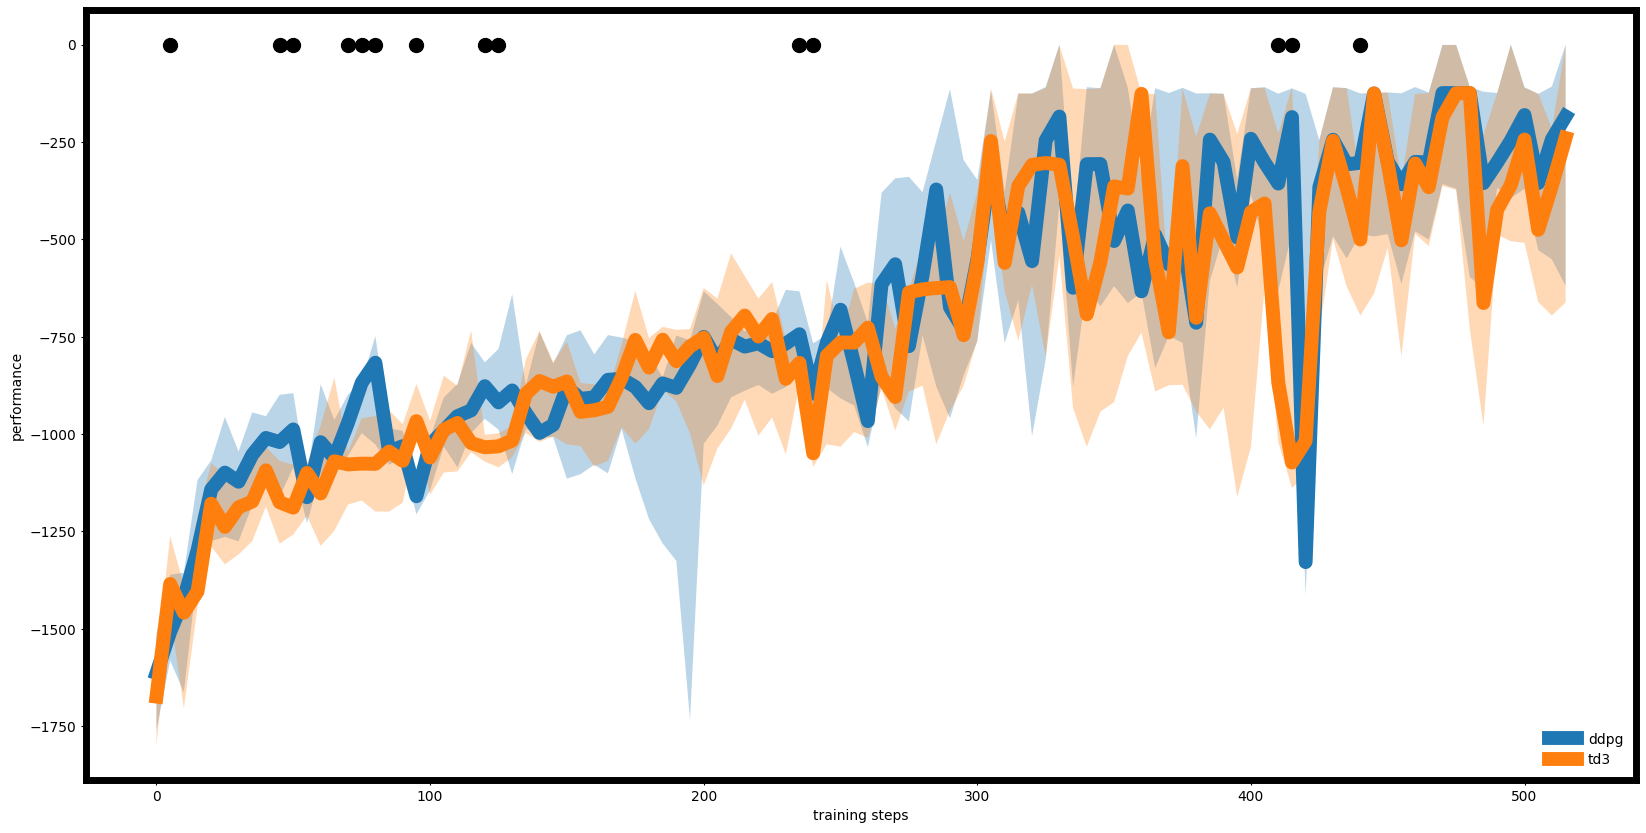

In [24]:
from bbrl.stats import WelchTTest

WelchTTest().plot(
    torch.stack(ddpg.eval_rewards),
    torch.stack(td3.eval_rewards),
    legends="ddpg/td3",
    save=True,
)